In [1]:
import os
import sys
import numpy as np
import pickle
import torch
import torchvision.models as models

In [2]:
with open("imagenet_labels.pkl", "rb") as f:
    class_name = pickle.load(f)

In [3]:
model = models.resnet18(pretrained=True)

In [4]:
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [21]:
import torch.nn as nn

a = 0

for i in model.modules():
    if type(i) == nn.Conv2d or type(i) == nn.BatchNorm2d or type(i) == nn.ReLU:
        print(i)
        a += 1
    
print(a)

ReLU(inplace)
ReLU(inplace)
ReLU(inplace)
ReLU(inplace)
ReLU(inplace)
ReLU(inplace)
ReLU(inplace)
ReLU(inplace)
ReLU(inplace)
9


In [20]:
a = 0
for name, module in model.named_modules():
    print(name)
    #if type(module) == nn.Conv2d or type(module) == nn.BatchNorm2d or type(module) == nn.ReLU:
    #    print(name)
    #    a += 1
    
print(a)


conv1
bn1
relu
maxpool
layer1
layer1.0
layer1.0.conv1
layer1.0.bn1
layer1.0.relu
layer1.0.conv2
layer1.0.bn2
layer1.1
layer1.1.conv1
layer1.1.bn1
layer1.1.relu
layer1.1.conv2
layer1.1.bn2
layer2
layer2.0
layer2.0.conv1
layer2.0.bn1
layer2.0.relu
layer2.0.conv2
layer2.0.bn2
layer2.0.downsample
layer2.0.downsample.0
layer2.0.downsample.1
layer2.1
layer2.1.conv1
layer2.1.bn1
layer2.1.relu
layer2.1.conv2
layer2.1.bn2
layer3
layer3.0
layer3.0.conv1
layer3.0.bn1
layer3.0.relu
layer3.0.conv2
layer3.0.bn2
layer3.0.downsample
layer3.0.downsample.0
layer3.0.downsample.1
layer3.1
layer3.1.conv1
layer3.1.bn1
layer3.1.relu
layer3.1.conv2
layer3.1.bn2
layer4
layer4.0
layer4.0.conv1
layer4.0.bn1
layer4.0.relu
layer4.0.conv2
layer4.0.bn2
layer4.0.downsample
layer4.0.downsample.0
layer4.0.downsample.1
layer4.1
layer4.1.conv1
layer4.1.bn1
layer4.1.relu
layer4.1.conv2
layer4.1.bn2
avgpool
fc
0


In [17]:
a = "layer2.0.downsample.0"

In [19]:
"downsample" in a

True

In [5]:
import requests
# IMAGENET
img_url = "http://farm2.static.flickr.com/1131/681589138_e4b702f863.jpg"
get_img = requests.get(img_url)

open('test.png', 'wb').write(get_img.content)

79701

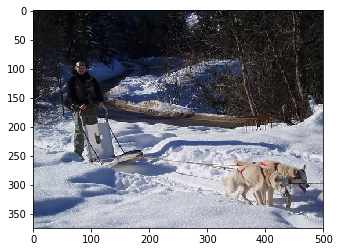

In [7]:
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

img_path = 'test.png'

img = Image.open(img_path)

plt.imshow(img)

In [8]:
feature = []

def get_feature(module, input, output):
    feature.append(output.cpu().data.numpy())

model._modules.get('layer4').register_forward_hook(get_feature)

params = list(model.parameters())
class_weights = np.squeeze(params[-2].cpu().data.numpy())

In [9]:
import torchvision.transforms as transforms
from torch.autograd import Variable

cvt_tensor = transforms.Compose([transforms.Resize((224,224)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

tensor_img = cvt_tensor(img).view(1, 3, 224, 224)

In [10]:
output = model(tensor_img)

In [11]:
from torch.nn import functional as F

h_x = F.softmax(output, dim=1).data.squeeze()

In [12]:
pred = h_x.argmax(0).item()
print("Predict Class Number : %d \nPridict Class Name : %s" % (pred, class_name[pred]))

Predict Class Number : 537 
Pridict Class Name : dogsled, dog sled, dog sleigh


In [13]:
for feature in feature:
    print(feature.shape)

(1, 512, 7, 7)


In [14]:
final_conv = feature[0]

cam = np.zeros(dtype=np.float32, shape=final_conv.shape[1:3])

for i, w in enumerate(class_weights[pred]):
    cam += w*final_conv[i,:,:]

In [15]:
def scaling(img):
    img = img - np.min(img)
    img = img / np.max(img)
    
    return img

scaled_cam = scaling(cam)

ValueError: operands could not be broadcast together with shapes (224,224,3) (128,128,3) 

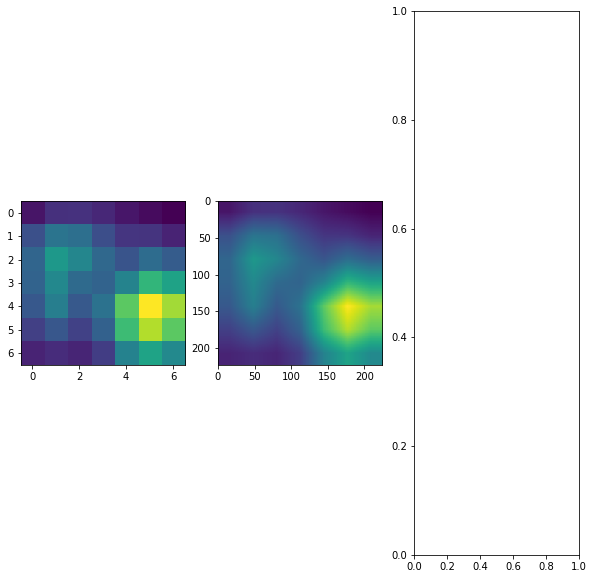

In [19]:
import cv2

fig, axs = plt.subplots(1, 3, figsize=(10,10))

axs[0].imshow(scaled_cam)

resized_cam = cv2.resize(scaled_cam, (128, 128))

axs[1].imshow(resized_cam)

heatmap = cv2.applyColorMap(np.uint8(255 * resized_cam), cv2.COLORMAP_JET)

img = cv2.imread(img_path)
img = cv2.resize(img, (128,128))
heatimg = heatmap*0.4 + img*0.5
cv2.imwrite('./cam.jpg', heatimg)

cam_img = cv2.imread('./cam.jpg')
cam_img = cv2.cvtColor(cam_img, cv2.COLOR_BGR2RGB)

axs[2].imshow(cam_img)

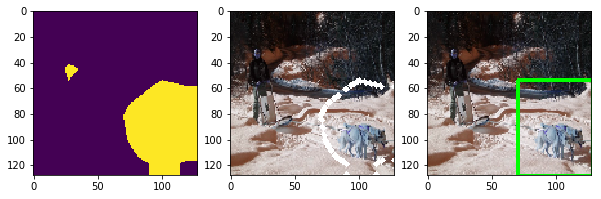

In [17]:
fig, axs = plt.subplots(1, 3, figsize=(10,10))

threshold = 0.5

_, thresholded_heatmap = cv2.threshold(resized_cam, threshold * resized_cam.max(), 1, cv2.THRESH_BINARY)

axs[0].imshow(thresholded_heatmap)

thresholded_heatmap = cv2.convertScaleAbs(thresholded_heatmap)
contours, _ = cv2.findContours(thresholded_heatmap, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

contour_areas = []   
for i, c in enumerate(contours):
    contour_areas.append(cv2.contourArea(c))
    
# contour 면적이 큰 순서대로 정렬
sorted_contours = sorted(zip(contour_areas, contours), key=lambda x:x[0], reverse=True)

# contour 면적이 큰 contours 선택
biggest_contour= sorted_contours[0][1]

# -1 : represent entire contours
# (255, 255, 255): color
# 3 : thinkness 
contour_image = cv2.drawContours(img.copy(), biggest_contour, -1, (255, 255, 255), 3)
axs[1].imshow(contour_image)

x,y,w,h = cv2.boundingRect(biggest_contour)
box_image = cv2.rectangle(img.copy(), (x,y), (x+w, y+h), (0, 255,0), 2)

axs[2].imshow(box_image)

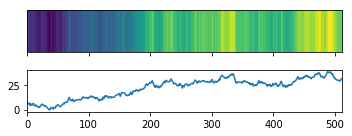

In [18]:
import matplotlib.pyplot as plt
import numpy as np; np.random.seed(1)
plt.rcParams["figure.figsize"] = 5,2

x = np.arange(512)
y = np.cumsum(np.random.randn(512))+6

fig, (ax,ax2) = plt.subplots(nrows=2, sharex=True)

extent = [x[0]-(x[1]-x[0])/2., x[-1]+(x[1]-x[0])/2.,0,1]
ax.imshow(y[np.newaxis,:], aspect="auto", extent=extent)
ax.set_yticks([])
ax.set_xlim(extent[0], extent[1])

ax2.plot(x,y)

plt.tight_layout()
plt.show()